# Data Retrieval

## Game scores


In this part I will retrieve data from the official site of the French basketball league using Selenium. Note that all web selenium elements in the code are prefixed by `se_`.

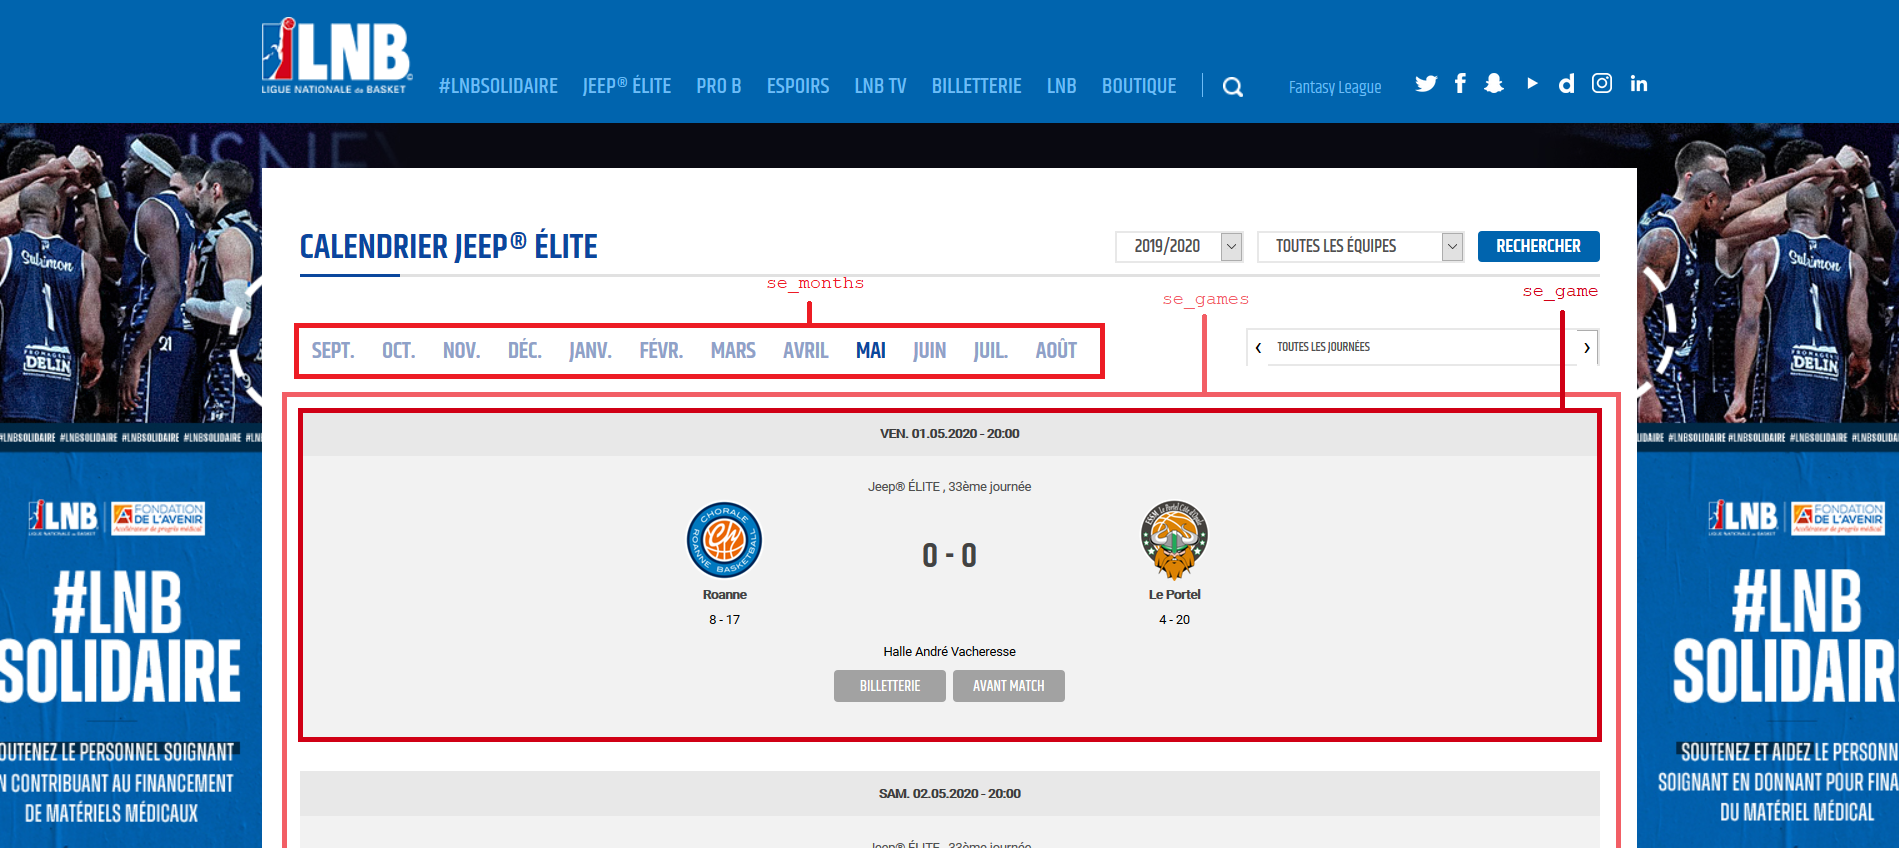

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time

In [ ]:
SEASONS_TO_BE_PROCESSED = ['2016', '2017', '2018', '2019']

In [ ]:
GAME_LIST_URL = "https://www.lnb.fr/fr/pro-a/calendrier-proa-25.html"
games = pd.DataFrame(columns=[
    'season',
    'date', 
    'home_team', 
    'home_score',
    'away_team',
    'away_score',
    'home_qt_1_pts',
    'away_qt_1_pts',
    'home_qt_2_pts',
    'away_qt_2_pts',
    'home_qt_3_pts',
    'away_qt_3_pts',
    'home_qt_4_pts',
    'away_qt_4_pts',
    'home_ot_1_pts',
    'away_ot_1_pts',
    'home_ot_2_pts',
    'away_ot_2_pts',
    'home_ot_3_pts',
    'away_ot_3_pts',
    'boxscore_url'
#     'is_on_tv'
])

# Instanciating the browser + disabiling images to fasten process and avoid useless data pulling
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
profile = webdriver.FirefoxProfile()
profile.set_preference("permissions.default.image", 2)
caps = DesiredCapabilities().FIREFOX
caps["pageLoadStrategy"] = "eager"


# Selecting season
for season in SEASONS_TO_BE_PROCESSED:
    # Instanciating the browser
    driver = webdriver.Firefox(firefox_profile=profile, desired_capabilities=caps)
    driver.get(GAME_LIST_URL)
    (driver.page_source).encode('utf-8')
    
    driver.find_element(By.XPATH, f"//select[@id='season']/option[@value='{season}']").click()
    driver.find_element(By.XPATH, '/html/body/div[2]/section/div/form/input').click()

    # Retrieving game data (not)
    se_months = driver.find_element(By.XPATH, "/html/body/div[2]/section/nav/ul").find_elements(By.TAG_NAME, "li")

    for se_month in se_months:
        se_month.click()
        time.sleep(1)
        month = se_month.get_attribute('data-month')
        nb_games = len(driver.find_elements(By.XPATH, f"/html/body/div[2]/section/section/section[@data-month='{month}']/div"))

        for game_idx in range(1, nb_games + 1):
            # Game score
            se_game_xpath = f"/html/body/div[2]/section/section/section[@data-month='{month}']/div[{str(game_idx)}]"
            game_score = driver.find_element(By.XPATH, f"{se_game_xpath}//div[@class='game-result']").text.split()
            home_score = int(game_score[0])
            away_score = int(game_score[2])

            if home_score > 0 and away_score > 0: # Games not played yet are displayed but as 0-0.
                # Game date
                game_date = driver.find_element(By.XPATH, f"{se_game_xpath}/div[1]/span").text
                game_date = pd.to_datetime(game_date[5:15], format="%d.%m.%Y")

                # Teams
                home_team = driver.find_element(By.XPATH, f"{se_game_xpath}//div[@class='team'][1]//span[@class='team-name']").text
                away_team = driver.find_element(By.XPATH, f"{se_game_xpath}//div[@class='team'][2]//span[@class='team-name']").text

                # Qts scores
                qt_1_2_scores = driver.find_element(By.XPATH, f"{se_game_xpath}//div[@class='game-quarters']/div/span[1]").text.split()
                qt_3_4_scores = driver.find_element(By.XPATH, f"{se_game_xpath}//div[@class='game-quarters']/div/span[2]").text.split()
                home_qt_1_pts = int(qt_1_2_scores[0])
                away_qt_1_pts = int(qt_1_2_scores[2])
                home_qt_2_pts = int(qt_1_2_scores[4]) - home_qt_1_pts
                away_qt_2_pts = int(qt_1_2_scores[6]) - away_qt_1_pts
                home_qt_3_pts = int(qt_3_4_scores[1]) - home_qt_2_pts - home_qt_1_pts
                away_qt_3_pts = int(qt_3_4_scores[3]) - away_qt_2_pts - away_qt_1_pts
                home_qt_4_pts = int(qt_3_4_scores[5]) - home_qt_3_pts - home_qt_2_pts - home_qt_1_pts
                away_qt_4_pts = int(qt_3_4_scores[7]) - away_qt_3_pts - away_qt_2_pts - away_qt_1_pts

                # OT
                home_ot_1_pts = None
                away_ot_1_pts = None
                home_ot_2_pts = None
                away_ot_2_pts = None
                home_ot_3_pts = None
                away_ot_3_pts = None
                
                try:
                    overtimes = driver.find_elements(By.XPATH, f"{se_game_xpath}//div[@class='score-result']/span[@class='over']")
                    nb_overtimes = len(overtimes)

                    for i in range(1, nb_overtimes+1):
                        ot = overtimes[i-1].text.split()

                        if (i == 1):
                            home_ot_1_pts = int(ot[0]) - home_qt_4_pts - home_qt_3_pts - home_qt_2_pts - home_qt_1_pts
                            away_ot_1_pts = int(ot[2]) - away_qt_4_pts - away_qt_3_pts - away_qt_2_pts - away_qt_1_pts
                        elif (i == 2):
                            home_ot_2_pts = int(ot[0]) - home_ot_1_pts - home_qt_4_pts - home_qt_3_pts - home_qt_2_pts - home_qt_1_pts
                            away_ot_2_pts = int(ot[2]) - away_ot_1_pts - away_qt_4_pts - away_qt_3_pts - away_qt_2_pts - away_qt_1_pts
                        elif (i == 3):
                            home_ot_3_pts = int(ot[0]) - home_ot_2_pts - home_ot_1_pts - home_qt_4_pts - home_qt_3_pts - home_qt_2_pts - home_qt_1_pts
                            away_ot_3_pts = int(ot[2]) - away_ot_2_pts - away_ot_1_pts - away_qt_4_pts - away_qt_3_pts - away_qt_2_pts - away_qt_1_pts
                except NoSuchElementException:
                    pass

                # Box-score URL
                boxscore_url = driver.find_element(By.XPATH, f"{se_game_xpath}//div[@class='btns']/a[1]").get_attribute('href')

                # Save game
                games = games.append({
                    'season': season,
                    'date': game_date, 
                    'home_team': home_team,
                    'home_score': home_score,
                    'away_team': away_team,
                    'away_score': away_score,
                    'home_qt_1_pts': home_qt_1_pts,
                    'away_qt_1_pts': away_qt_1_pts,
                    'home_qt_2_pts': home_qt_2_pts,
                    'away_qt_2_pts': away_qt_2_pts,
                    'home_qt_3_pts': home_qt_3_pts,
                    'away_qt_3_pts': away_qt_3_pts,
                    'home_qt_4_pts': home_qt_4_pts,
                    'away_qt_4_pts': away_qt_4_pts,
                    'home_ot_1_pts': home_ot_1_pts,
                    'away_ot_1_pts': away_ot_1_pts,
                    'home_ot_2_pts': home_ot_2_pts,
                    'away_ot_2_pts': away_ot_2_pts,
                    'home_ot_3_pts': home_ot_3_pts,
                    'away_ot_3_pts': away_ot_3_pts,
                    'boxscore_url': boxscore_url
                }, ignore_index=True)

    driver.close()

# Saving to CSV
games.to_csv('data/game_scores.csv', index=False, encoding="utf-8")

If the game list has already been retrieved, it can be loaded using this cell:

In [ ]:
games = pd.read_csv('data/game_scores.csv', encoding="utf-8")

## Games statistics

We will retrieve total points, rebounds, assist, steals etc. for each team and each game retrieve previously. In case of doubt on any statistical term, feel free to use [this glossary](https://en.wikipedia.org/wiki/Glossary_of_basketball_terms).

> **/!\ Warning, this part may take multiple hours to execute as it goes through all games' statistics page to pull them.**

In [ ]:
games_stats = pd.DataFrame(columns=[
    'boxscore_url', # Join with the game list/scores pulled above
    'minutes',
    'home_ast', # Assists
    'home_drbd', # Defensive Rebounds
    'home_orbd', # Offensive rebounds
    'home_2pa', # 2 points attempts
    'home_2pm', # 2 points made
    'home_3pa', # 3 points attempts
    'home_3pm', # 3 points made
    'home_fta', # free-throws attempts
    'home_ftm', # free-throws made
    'home_blk', # blocks
    'home_stl', # steals
    'home_tov', # turnovers
    'home_pf', # personal fouls
    'home_pfd', # personal fouls drawn
    'away_ast', 
    'away_drbd', 
    'away_orbd', 
    'away_2pa', 
    'away_2pm', 
    'away_3pa', 
    'away_3pm', 
    'away_fta', 
    'away_ftm', 
    'away_blk', 
    'away_stl', 
    'away_tov', 
    'away_pf', 
    'away_pfd' 
])

# Instanciating the browser + disabiling images to fasten process and avoid useless data pulling
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
profile = webdriver.FirefoxProfile()
profile.set_preference("permissions.default.image", 2)
caps = DesiredCapabilities().FIREFOX
caps["pageLoadStrategy"] = "eager"

# Counter
total_games = len(games['boxscore_url'])
nb_processed = 1

# Loop for each game
for idx, game in games.iterrows():
    # Displaying counter and incrementing it.
    print(f"Processing {game.home_team}-{game.away_team}. {nb_processed}/{total_games} ({round(nb_processed/total_games*100, 2)}%)")
    nb_processed += 1
    
    game_url = game['boxscore_url']
    driver = webdriver.Firefox(firefox_profile=profile, desired_capabilities=caps)
    driver.get(game_url)
    
    se_total_stats = driver.find_elements(By.TAG_NAME, "tfoot")
    
    # Home team stats
    se_total_home_stats = se_total_stats[0].find_elements(By.XPATH, "./tr/td")
    minutes = int(se_total_home_stats[2].text)
    home_ast = int(se_total_home_stats[15].text)
    home_drbd = int(se_total_home_stats[11].text)
    home_orbd = int(se_total_home_stats[10].text)
    home_total_shots_made, home_total_shots_attempts = list(map(int,se_total_home_stats[4].text.split('-'))) # this is the total shots, and embbed 3pts  
    home_3pm, home_3pa = list(map(int, se_total_home_stats[6].text.split('-')))
    home_2pm, home_2pa = home_total_shots_made - home_3pm, home_total_shots_attempts - home_3pa # removing 3pts to have only 2pts shots
    home_ftm, home_fta = list(map(int,se_total_home_stats[8].text.split('-')))
    home_blk = int(se_total_home_stats[13].text)
    home_stl = int(se_total_home_stats[16].text)
    home_tov = int(se_total_home_stats[17].text)
    home_pf = int(se_total_home_stats[18].text)
    home_pfd = int(se_total_home_stats[19].text)
    
    # Away team stats
    se_total_away_stats = se_total_stats[1].find_elements(By.XPATH, "./tr/td")
    away_ast = int(se_total_away_stats[15].text)
    away_drbd = int(se_total_away_stats[11].text)
    away_orbd = int(se_total_away_stats[10].text)
    away_total_shots_made, away_total_shots_attempts = list(map(int,se_total_away_stats[4].text.split('-'))) # this is the total shots, and embbed 3pts  
    away_3pm, away_3pa = list(map(int, se_total_away_stats[6].text.split('-')))
    away_2pm, away_2pa = away_total_shots_made - away_3pm, away_total_shots_attempts - away_3pa # removing 3pts to have only 2pts shots
    away_ftm, away_fta = list(map(int,se_total_away_stats[8].text.split('-')))
    away_blk = int(se_total_away_stats[13].text)
    away_stl = int(se_total_away_stats[16].text)
    away_tov = int(se_total_away_stats[17].text)
    away_pf = int(se_total_away_stats[18].text)
    away_pfd = int(se_total_away_stats[19].text)
    
    games_stats = games_stats.append({
        'boxscore_url': game_url,
        'minutes': minutes,
        'home_ast': home_ast, 
        'home_drbd': home_drbd,
        'home_orbd': home_orbd, 
        'home_2pa': home_2pa, 
        'home_2pm': home_2pm,
        'home_3pa': home_3pa,
        'home_3pm': home_3pm, 
        'home_fta': home_fta,
        'home_ftm': home_ftm,
        'home_blk': home_blk,
        'home_stl': home_stl,
        'home_tov': home_tov,
        'home_pf': home_pf,
        'home_pfd': home_pfd,
        'away_ast': away_ast, 
        'away_drbd': away_drbd, 
        'away_orbd': away_orbd, 
        'away_2pa': away_2pa, 
        'away_2pm': away_2pm, 
        'away_3pa': away_3pa, 
        'away_3pm': away_3pm, 
        'away_fta': away_fta, 
        'away_ftm': away_ftm, 
        'away_blk': away_blk, 
        'away_stl': away_stl, 
        'away_tov': away_tov, 
        'away_pf': away_pf, 
        'away_pfd': away_pfd
    }, ignore_index=True)
    
    driver.close()

# Saving to CSV
games_stats.to_csv('data/games_statistics.csv', index=False, encoding="utf-8")